# Requirements

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense
from xgboost import XGBRegressor

In [ ]:
# Add as many imports as you need.

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of the current **close price** for the Amazon stock. To accomplish this, you will use data from the preceding 7 days, and past statistics. 


## The Amazon Stock Price Dataset

The dataset comprises the following columns:
- date - the date of the recorded price
- open - the open price of the stock
- high - the high price of the stock
- low - the low price of the stock
- volume - the volume trades
- close - the close price of the stock

Target:
close

Load the dataset into a `pandas` data frame.

In [2]:
# Write your code here. Add as many boxes as you need.
df = pd.read_csv("amazon_stock_price.csv")
df

,date,open,high,low,close,volume
0,1997-05-15,0.1219,0.1250,0.0964,0.0979,1443120000
1,1997-05-16,0.0984,0.0990,0.0854,0.0865,294000000
2,1997-05-19,0.0880,0.0885,0.0812,0.0854,122136000
3,1997-05-20,0.0865,0.0875,0.0818,0.0818,109344000
4,1997-05-21,0.0818,0.0823,0.0688,0.0714,377064000
...,...,...,...,...,...,...
6680,2023-11-30,144.7600,146.9300,144.3300,146.0900,65814000
6681,2023-12-01,146.0000,147.2500,145.5500,147.0300,39924600
6682,2023-12-04,145.2500,145.3500,142.8100,144.8400,48294200
6683,2023-12-05,143.5500,148.5700,143.1300,146.8800,46822400


In [3]:
df["date"] = pd.to_datetime(df["date"])
df.set_index(keys=["date"], inplace=True)
df.sort_index(inplace=True)
df

,open,high,low,close,volume
date,,,,,
1997-05-15,0.1219,0.1250,0.0964,0.0979,1443120000
1997-05-16,0.0984,0.0990,0.0854,0.0865,294000000
1997-05-19,0.0880,0.0885,0.0812,0.0854,122136000
1997-05-20,0.0865,0.0875,0.0818,0.0818,109344000
1997-05-21,0.0818,0.0823,0.0688,0.0714,377064000
...,...,...,...,...,...
2023-11-30,144.7600,146.9300,144.3300,146.0900,65814000
2023-12-01,146.0000,147.2500,145.5500,147.0300,39924600
2023-12-04,145.2500,145.3500,142.8100,144.8400,48294200


Explore the dataset using visualizations of your choice.

In [5]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

<Axes: >

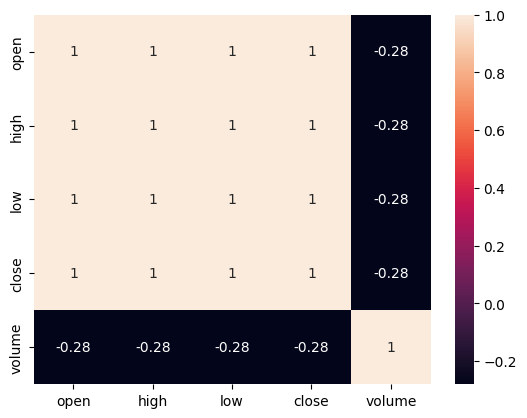

In [6]:
# Write your code here. Add as many boxes as you need.
sns.heatmap(df.corr(), annot=True)

In [7]:
df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
df

,close
date,
1997-05-15,0.0979
1997-05-16,0.0865
1997-05-19,0.0854
1997-05-20,0.0818
1997-05-21,0.0714
...,...
2023-11-30,146.0900
2023-12-01,147.0300
2023-12-04,144.8400


# Feauture Extraction
Select the relevant features for prediction and apply a lag of up to 7 days to each chosen feature

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [8]:
# Write your code here. Add as many boxes as you need.
lag = 7

In [9]:
periods = range(lag, 0, -1)

In [10]:
df.shift(periods=periods)

,close_7,close_6,close_5,close_4,close_3,close_2,close_1
date,,,,,,,
1997-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-16,NaN,NaN,NaN,NaN,NaN,NaN,0.0979
1997-05-19,NaN,NaN,NaN,NaN,NaN,0.0979,0.0865
1997-05-20,NaN,NaN,NaN,NaN,0.0979,0.0865,0.0854
1997-05-21,NaN,NaN,NaN,0.0979,0.0865,0.0854,0.0818
...,...,...,...,...,...,...,...
2023-11-30,146.13,143.90,146.71,146.7400,147.7300,147.0300,146.3200
2023-12-01,143.90,146.71,146.74,147.7300,147.0300,146.3200,146.0900
2023-12-04,146.71,146.74,147.73,147.0300,146.3200,146.0900,147.0300


In [11]:
df = pd.concat([df, df.shift(periods=periods)], axis=1)

In [12]:
df

,close,close_7,close_6,close_5,close_4,close_3,close_2,close_1
date,,,,,,,,
1997-05-15,0.0979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-16,0.0865,NaN,NaN,NaN,NaN,NaN,NaN,0.0979
1997-05-19,0.0854,NaN,NaN,NaN,NaN,NaN,0.0979,0.0865
1997-05-20,0.0818,NaN,NaN,NaN,NaN,0.0979,0.0865,0.0854
1997-05-21,0.0714,NaN,NaN,NaN,0.0979,0.0865,0.0854,0.0818
...,...,...,...,...,...,...,...,...
2023-11-30,146.0900,146.13,143.90,146.71,146.7400,147.7300,147.0300,146.3200
2023-12-01,147.0300,143.90,146.71,146.74,147.7300,147.0300,146.3200,146.0900
2023-12-04,144.8400,146.71,146.74,147.73,147.0300,146.3200,146.0900,147.0300


In [13]:
df.dropna(axis=0, inplace=True)

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [16]:
# Write your code here. Add as many boxes as you need.
X, y = df.drop(columns=["close"]), df["close"]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle=False)

In [17]:
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [18]:
lag = 7
(train_X.shape[0], lag, (train_X.shape[1] // lag))

(5342, 7, 1)

## Ensemble Learning Methods

### Boosting

Create an instance of an XGBoost model and train it using the `fit` function.

In [29]:
# Write your code here. Add as many boxes as you need.
regressor = XGBRegressor(n_estimators=30).fit(train_X, train_y)

Use the trained model to make predictions for the test set.

In [30]:
# Write your code here. Add as many boxes as you need.
pred_y = regressor.predict(test_X)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [31]:
# Write your code here. Add as many boxes as you need.
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
(mean_absolute_error(test_y, pred_y), mean_squared_error(test_y, pred_y), r2_score(test_y, pred_y))

(np.float64(33.89802646595847),
 np.float64(2040.718705643287),
 -1.0057855613504776)

In [32]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [33]:
grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid={
        "n_estimators": [20, 25, 30, 35, 40, 50, 60, 70],
        "max_depth": [2, 3, 4, 5, 6, 7, 8, 10]
    },
    cv=TimeSeriesSplit(n_splits=5)
)

In [34]:
grid_search.fit(train_X, train_y)

D:\anaconda\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 10],
                         'n_estimators': [20, 25, 30, 35, 40, 50, 60, 70]})

In [35]:
grid_search.best_params_

{'max_depth': 6, 'n_estimators': 40}

In [36]:
regressor = XGBRegressor(n_estimators=40, max_depth=6).fit(train_X, train_y)

In [37]:
pred_y = regressor.predict(test_X)

In [38]:
(mean_absolute_error(test_y, pred_y), mean_squared_error(test_y, pred_y), r2_score(test_y, pred_y))

(np.float64(33.90521482552169),
 np.float64(2041.0972925977667),
 -1.0061576676309323)

# LSTM

In [39]:
X, y = df.drop(columns=["close"]), df["close"]

In [40]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle=False)

In [41]:
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [42]:
scaler = MinMaxScaler()
train_y = scaler.fit_transform(train_y.to_numpy().reshape(-1, 1))

In [43]:
lag = 7
(train_X.shape[0], lag, (train_X.shape[1] // lag))

(5342, 7, 1)

In [44]:
train_X = train_X.reshape((train_X.shape[0], lag, (train_X.shape[1] // lag)))
test_X = test_X.reshape((test_X.shape[0], lag, (test_X.shape[1] // lag)))

In [71]:
model = Sequential([
    Input((train_X.shape[1], train_X.shape[2],)),
    LSTM(8, activation="relu", return_sequences=True),
    LSTM(4, activation="relu"),
    Dense(1, activation="linear")
])

In [72]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 7, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 4)                   │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 533 (2.08 KB)

 Trainable params: 533 (2.08 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=["mean_squared_error"],
)

In [74]:
history = model.fit(train_X, train_y, validation_split=0.20, epochs=4, batch_size=16, shuffle=False)

Epoch 1/4
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.1007e-04 - mean_squared_error: 1.1007e-04 - val_loss: 0.0680 - val_mean_squared_error: 0.0680
Epoch 2/4
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.1063 - val_mean_squared_error: 0.1063
Epoch 3/4
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.1123 - val_mean_squared_error: 0.1123
Epoch 4/4
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.1145 - val_mean_squared_error: 0.1145


<Axes: >

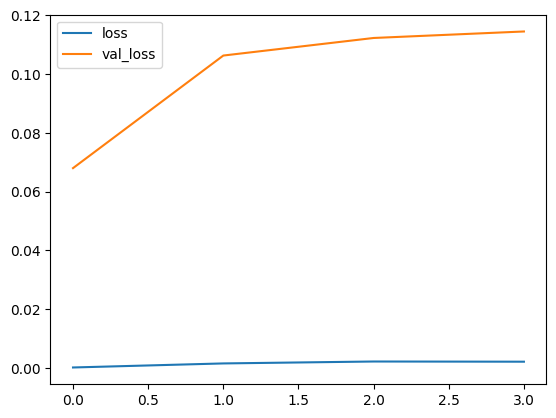

In [75]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [76]:
pred_y = model.predict(test_X)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [77]:
pred_y = scaler.inverse_transform(pred_y)

In [78]:
r2_score(test_y, pred_y)

-11.125919538817156